# spark wordcount 1

In [1]:
!pip install pyspark

In [2]:
!pip install seaborn

In [3]:
!pip install tabulate

In [4]:
# import libraries
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession

from pyspark.sql.window import Window
from pyspark.sql.functions import udf, isnan, min, max, sum, count, desc, expr, avg
from pyspark.sql.types import IntegerType, LongType

from pyspark.ml.feature import StandardScaler, VectorAssembler, MinMaxScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, LogisticRegression, GBTClassifier, LogisticRegressionModel, GBTClassificationModel, RandomForestClassificationModel

import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import numpy as np
import pandas as pd
import re  # Добавляем импорт модуля re
from tabulate import tabulate
import matplotlib.pyplot as plt

In [5]:
from pyspark.sql import SparkSession

# Создание SparkSession
spark = SparkSession.builder \
    .appName("WordCount App") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://localhost:9000") \
    .config("spark.ui.port", "4050") \
    .getOrCreate()

# Установка количества разделов для shuffle операций
spark.conf.set("spark.sql.shuffle.partitions", "50")

# Чтение данных из HDFS (текстовый файл)
file_path = "hdfs://localhost:9000/userkd/var11/delivery.csv"
df = spark.read.csv(file_path)  # Используем .csv, так как это текстовый файл

# Печать первых нескольких строк
df.show()



25/04/22 23:32:52 WARN Utils: Your hostname, devopsvm resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
25/04/22 23:32:52 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/22 23:33:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+-----------+----------+---------------+---------------+-----------+-----------------+---------+
|        _c0|       _c1|            _c2|            _c3|        _c4|              _c5|      _c6|
+-----------+----------+---------------+---------------+-----------+-----------------+---------+
|delivery_id|      date|         origin|    destination|distance_km|delivery_time_min|   status|
|          1|2025-04-13|         Москва|   Екатеринбург|       1473|              738|  delayed|
|          2|2025-04-18|Нижний Новгород|        Воронеж|        724|              415|  delayed|
|          3|2025-04-01|Санкт-Петербург|         Самара|        980|              647|delivered|
|          4|2025-04-08|         Казань|         Самара|        231|              122|delivered|
|          5|2025-04-21|Санкт-Петербург|         Казань|        883|              570|delivered|
|          6|2025-04-10|   Екатеринбург|         Самара|        115|               47|delivered|
|          7|2025-04-05|   Ека

In [6]:
df.show()

+-----------+----------+---------------+---------------+-----------+-----------------+---------+
|        _c0|       _c1|            _c2|            _c3|        _c4|              _c5|      _c6|
+-----------+----------+---------------+---------------+-----------+-----------------+---------+
|delivery_id|      date|         origin|    destination|distance_km|delivery_time_min|   status|
|          1|2025-04-13|         Москва|   Екатеринбург|       1473|              738|  delayed|
|          2|2025-04-18|Нижний Новгород|        Воронеж|        724|              415|  delayed|
|          3|2025-04-01|Санкт-Петербург|         Самара|        980|              647|delivered|
|          4|2025-04-08|         Казань|         Самара|        231|              122|delivered|
|          5|2025-04-21|Санкт-Петербург|         Казань|        883|              570|delivered|
|          6|2025-04-10|   Екатеринбург|         Самара|        115|               47|delivered|
|          7|2025-04-05|   Ека

In [9]:
# Посмотрим схему
df.printSchema()



root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)
 |-- _c6: string (nullable = true)



In [15]:

from pyspark.sql.functions import col, avg

# Среднее время доставки (только для доставленных)
df.filter(col("_c6") == "delivered") \
  .agg(avg(col("_c5").cast("double")).alias("avg_delivery_time")) \
  .show()

+-----------------+
|avg_delivery_time|
+-----------------+
|449.6865671641791|
+-----------------+



In [16]:
# Процент доставленных заказов
total = df.count()
delivered = df.filter(col("_c6") == "delivered").count()
print(f"Процент доставленных: {delivered / total * 100:.2f}%")

Процент доставленных: 66.34%


In [17]:
# Эффективность: мин/км
df = df.withColumn("min_per_km", 
                  col("_c5").cast("double") / 
                  col("_c4").cast("double"))

df.filter(col("_c6") == "delivered") \
  .agg(avg("min_per_km").alias("avg_min_per_km")) \
  .show()

+------------------+
|    avg_min_per_km|
+------------------+
|0.5145916386308724|
+------------------+



UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('<U4'), dtype('float64')) -> None

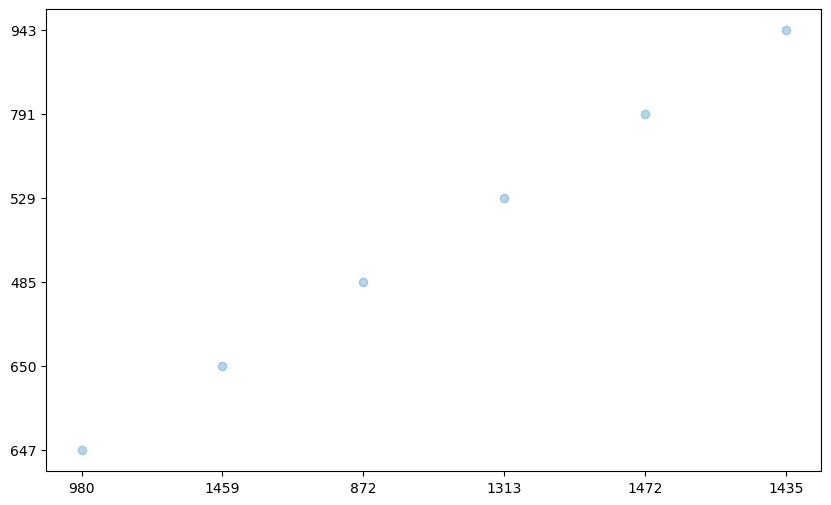

In [19]:
# Visualization: Distance vs Delivery Time for delivered orders
plt.figure(figsize=(10, 6))

# Convert a sample of delivered orders to Pandas for plotting
delivered_sample = df.filter(col("_c6") == "delivered") \
                   .filter(col("_c4").isNotNull() & col("_c5").isNotNull()) \
                   .sample(0.1).toPandas()

# Scatter plot with regression line
sns.regplot(x='_c4', y='_c5', data=delivered_sample, 
            scatter_kws={'alpha':0.3}, line_kws={'color':'red'})

plt.title('Delivery Time vs Distance for Successful Deliveries')
plt.xlabel('Distance (km)')
plt.ylabel('Delivery Time (minutes)')
plt.grid(True)

# Calculate and display average efficiency
valid_samples = delivered_sample[['_c4', '_c5']].dropna()
if not valid_samples.empty:
    avg_efficiency = valid_samples['_c5'].mean() / valid_samples['_c4'].mean()
    plt.text(0.05, 0.95, f"Avg efficiency: {avg_efficiency:.2f} min/km", 
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.8))

plt.show()
